# Laboratorio 3 - Análisis GeoEspacial y Sensores Remotos

# Laboratorio 3 – Análisis GeoEspacial y Sensores Remotos
**Curso:** CC3084 – Data Science  
**Tema:** Monitoreo de deforestación en Petén, Guatemala usando imágenes Sentinel-2  
**Integrantes:** 
- Nelson Garcia
- Brandon Reyes



### Importar librerías a usar:

In [1]:
from pathlib import Path
import re
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt


Se importamos las librerías necesarias para el procesamiento de imágenes satelitales:
- **pathlib, re**: manejo de rutas y expresiones regulares para organizar archivos.
- **numpy**: operaciones numéricas y matriciales.
- **rasterio**: lectura, escritura y reproyección de archivos geoespaciales.
- **matplotlib**: visualización de mapas y resultados.


## Carga de imágenes:



In [2]:
IMAGES_DIR = Path("images")
OUT_DIR = Path("outputs")

In [3]:
# ----- Detectar banda y fecha según los nombres -----
def detect_band(p: Path):
    s = p.name.upper()
    if "B04" in s: return "red"
    if ("B08" in s or re.search(r"\bB8\b", s)) and "B8A" not in s: return "nir"
    return None

def parse_date(p: Path):
    # Toma el PRIMER YYYY-MM-DD que aparezca 
    m = re.search(r"(20\d{2}-\d{2}-\d{2})", p.name)
    if m: return m.group(1)
    m = re.search(r"(20\d{6})", p.name)
    if m:
        d = m.group(1); return f"{d[:4]}-{d[4:6]}-{d[6:]}"
    return p.stem

# ----- Lectura y alineación -----
def read_band_aligned(red_path: Path, nir_path: Path):
    with rasterio.open(nir_path) as dn, rasterio.open(red_path) as dr:
        nir = dn.read(1, masked=True).astype("float32")
        red = dr.read(1, masked=True).astype("float32")
        # Reproyecta RED al grid del NIR si hace falta
        if (red.shape != nir.shape) or (dr.transform != dn.transform) or (dr.crs != dn.crs):
            red_aligned = np.zeros(nir.shape, dtype="float32")
            reproject(
                source=red.filled(0),
                destination=red_aligned,
                src_transform=dr.transform, src_crs=dr.crs,
                dst_transform=dn.transform, dst_crs=dn.crs,
                resampling=Resampling.bilinear,
            )
            mask = (red_aligned == 0) | nir.mask
            red = np.ma.array(red_aligned, mask=mask)
        else:
            red.mask = red.mask | nir.mask
        return red, nir, dn.profile

En esta sección:
1. Detectamos las bandas B04 (rojo) y B08 (infrarrojo cercano) de Sentinel-2.
2. Emparejamos las bandas por fecha de adquisición.
3. Reproyectamos y alineamos las imágenes para que tengan la misma resolución, extensión y sistema de coordenadas.
4. El objetivo es garantizar que el cálculo del NDVI se realice píxel a píxel de forma correcta.

## Parte 3: Cálculo de NDVI y Detección de Cambios

In [4]:
def compute_ndvi(red, nir):
    denom = (nir + red)
    with np.errstate(divide="ignore", invalid="ignore"):
        ndvi = (nir - red) / denom
    bad = (denom == 0) | red.mask | nir.mask
    return np.ma.array(ndvi.astype("float32"), mask=bad)

def write_geotiff(path: Path, array_ma: np.ma.MaskedArray, ref_profile, dtype="float32", nodata_value=-9999):
    prof = ref_profile.copy()
    prof.update(driver="GTiff", dtype=dtype, count=1,
                nodata=(nodata_value if dtype!="uint8" else 0), compress="lzw")
    data = array_ma.filled(nodata_value if dtype!="uint8" else 0).astype(dtype)
    with rasterio.open(path, "w", **prof) as dst:
        dst.write(data, 1)

# ----- Buscar y emparejar -----
tiffs = sorted(IMAGES_DIR.glob("*.tif*"))
pairs = {}
for p in tiffs:
    band = detect_band(p)
    if band is None: continue
    date = parse_date(p)
    pairs.setdefault(date, {})
    pairs[date][band] = p

pairs = {d: b for d, b in pairs.items() if "red" in b and "nir" in b}
if not pairs:
    raise RuntimeError("No hay pares B04/B08 en 'images/'.")

print("Pares detectados:")
for d, b in pairs.items():
    print(f" - {d}: {b['red'].name} | {b['nir'].name}")

Pares detectados:
 - 2020-03-05: 2020-03-05-00_00_2020-03-05-23_59_Sentinel-2_L2A_B04_(Raw).tiff | 2020-03-05-00_00_2020-03-05-23_59_Sentinel-2_L2A_B08_(Raw).tiff
 - 2024-03-09: 2024-03-09-00_00_2024-03-09-23_59_Sentinel-2_L2A_B04_(Raw).tiff | 2024-03-09-00_00_2024-03-09-23_59_Sentinel-2_L2A_B08_(Raw).tiff


In [5]:
# ----- Calcular NDVI por fecha -----
ndvi_by_date = {}
profile_by_date = {}
for d, b in sorted(pairs.items()):
    red, nir, prof = read_band_aligned(b["red"], b["nir"])
    ndvi = compute_ndvi(red, nir)
    ndvi_by_date[d] = ndvi
    profile_by_date[d] = prof
    out_path = OUT_DIR / f"NDVI_{d}.tif"
    write_geotiff(out_path, ndvi, prof, dtype="float32", nodata_value=-9999)
    print(f"Guardado: {out_path.name}")

# -----  diferencia y umbral -----
fechas = sorted(ndvi_by_date.keys())
d0, d1 = fechas[0], fechas[-1]   # primera vs última 
ndvi0, ndvi1 = ndvi_by_date[d0], ndvi_by_date[d1]
prof0, prof1 = profile_by_date[d0], profile_by_date[d1]

# Alinear si fuera necesario
same_grid = (prof0["crs"] == prof1["crs"]) and (prof0["transform"] == prof1["transform"]) and (ndvi0.shape == ndvi1.shape)
if not same_grid:
    aligned = np.zeros(ndvi1.shape, dtype="float32")
    reproject(
        source=ndvi0.filled(-9999),
        destination=aligned,
        src_transform=prof0["transform"], src_crs=prof0["crs"],
        dst_transform=prof1["transform"], dst_crs=prof1["crs"],
        resampling=Resampling.bilinear,
    )
    ndvi0 = np.ma.array(aligned, mask=(aligned == -9999) | ndvi1.mask)

ndvi_diff = np.ma.array(ndvi1 - ndvi0, mask=ndvi1.mask | ndvi0.mask)
diff_path = OUT_DIR / f"NDVI_diff_{d1}_minus_{d0}.tif"
write_geotiff(diff_path, ndvi_diff, profile_by_date[d1], dtype="float32", nodata_value=-9999)
print(f"Guardado: {diff_path.name}")

threshold = -0.2
loss_mask = np.ma.array((ndvi_diff < threshold).astype("uint8"), mask=ndvi_diff.mask)  # 1 = pérdida
loss_path = OUT_DIR / f"NDVI_loss_mask_{d1}_minus_{d0}_th{threshold}.tif"
write_geotiff(loss_path, loss_mask, profile_by_date[d1], dtype="uint8")
print(f"Guardado: {loss_path.name} (1 = pérdida significativa)")


Guardado: NDVI_2020-03-05.tif
Guardado: NDVI_2024-03-09.tif
Guardado: NDVI_diff_2024-03-09_minus_2020-03-05.tif
Guardado: NDVI_loss_mask_2024-03-09_minus_2020-03-05_th-0.2.tif (1 = pérdida significativa)


El **NDVI (Normalized Difference Vegetation Index)** se calcula con la fórmula:

\[
NDVI = \frac{NIR - Red}{NIR + Red}
\]

- Valores cercanos a **1** indican vegetación muy saludable.
- Valores cercanos a **0** representan suelo desnudo o vegetación escasa.
- Valores negativos indican agua, nubes o superficies no vegetadas.

Pasos realizados:
1. Cálculo del NDVI para 2020 y 2024.
2. Creación de una imagen de **diferencia de NDVI** (2024 − 2020).
3. Aplicación de un **umbral -0.2** para identificar pérdida significativa de vegetación.
4. Exportación de mapas resultantes en formato GeoTIFF.


## Parte 4: Visualización y Reporte

### Imágenes resultantes

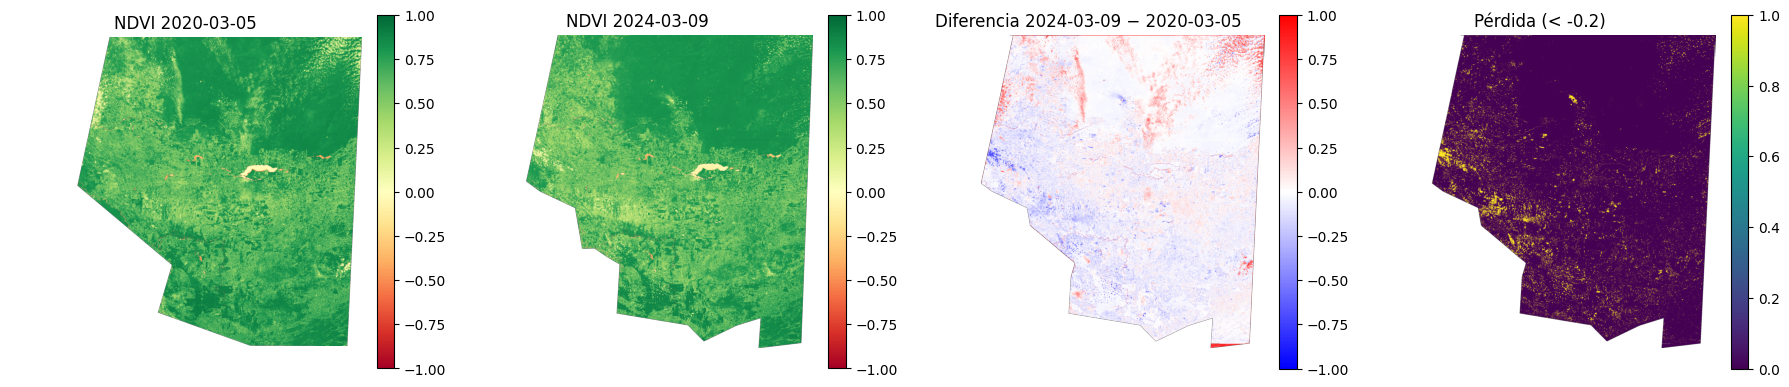

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
im0 = axs[0].imshow(ndvi_by_date[d0], vmin=-1, vmax=1, cmap="RdYlGn"); axs[0].set_title(f"NDVI {d0}"); plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
im1 = axs[1].imshow(ndvi_by_date[d1], vmin=-1, vmax=1, cmap="RdYlGn"); axs[1].set_title(f"NDVI {d1}"); plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
vmax = np.nanmax(np.abs(ndvi_diff.filled(np.nan))); vmax = 0.6 if not np.isfinite(vmax) else min(max(vmax, 0.3), 1.0)
im2 = axs[2].imshow(ndvi_diff, vmin=-vmax, vmax=vmax, cmap="bwr"); axs[2].set_title(f"Diferencia {d1} − {d0}"); plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
im3 = axs[3].imshow(loss_mask, vmin=0, vmax=1); axs[3].set_title(f"Pérdida (< -0.2)"); plt.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04)
for ax in axs: ax.axis("off")
plt.tight_layout(); plt.show()

Se generan los siguientes mapas:
- NDVI 2020
- NDVI 2024
- Diferencia de NDVI
- Máscara de pérdida de vegetación

La paleta de colores:
- **Verde**: vegetación saludable
- **Rojo**: pérdida de vegetación
- **Azul**: ganancia de vegetación


En el periodo comprendido entre marzo de 2020 y marzo de 2024, se evidencia un patrón mixto de cambios en la vegetación dentro del área analizada. Las imágenes de NDVI muestran una cobertura vegetal densa en ambas fechas, aunque con ligeras variaciones espaciales. El mapa de diferencia de NDVI revela áreas en tonos rojos, indicando pérdida de vegetación, y zonas azules, donde se ha producido un incremento. La presencia de ambos colores sugiere que han ocurrido procesos simultáneos de degradación y regeneración vegetal, probablemente asociados a dinámicas agrícolas, climáticas o de manejo del suelo. Finalmente, el mapa binario de pérdida (NDVI < -0.2) permite identificar de manera clara zonas donde la disminución del índice fue significativa. Estas áreas, marcadas en amarillo, se concentran principalmente en el norte y sur del territorio, lo cual puede estar relacionado con actividades de deforestación o expansión urbana. Este análisis es útil para orientar medidas de conservación y evaluar impactos ambientales a lo largo del tiempo.

### Cálculo del área de deforestación


In [7]:
from rasterio.warp import calculate_default_transform
from rasterio.crs import CRS

# --------- Parámetros ----------
threshold = -0.2            # Umbral de pérdida de NDVI
baseline_ndvi_thresh = 0.2  # Umbral para considerar "vegetación" en la fecha inicial

# --------- Utilidades ----------
def parse_date_from_name(name: str):
    m = re.search(r"(20\d{2}-\d{2}-\d{2})", name)
    if m: return m.group(1)
    m = re.search(r"(20\d{6})", name)
    if m:
        d = m.group(1); return f"{d[:4]}-{d[4:6]}-{d[6:]}"
    return name

def pick_files():
    diffs = sorted(OUT_DIR.glob("NDVI_diff_*.tif*"))
    if not diffs:
        raise RuntimeError("No encontré NDVI_diff_*.tif en 'outputs/'. Ejecuta antes el cálculo de NDVI y su diferencia.")
    diff_path = diffs[-1]  # el más reciente

    ndvi_files = sorted(OUT_DIR.glob("NDVI_*.tif*"))
    if len(ndvi_files) < 2:
        print("[AVISO] Sólo hay una fecha NDVI. El % respecto a vegetación inicial no podrá calcularse si no corresponde a la fecha inicial.")
    # Ordena por fecha inferida
    ndvi_files = sorted(ndvi_files, key=lambda p: parse_date_from_name(p.name))
    ndvi_start = ndvi_files[0]  # fecha inicial (p.ej., 2020-..)
    return diff_path, ndvi_start

def utm_crs_from_dataset(ds):
    # Calcula el centro en WGS84 y asigna UTM zona adecuada
    cx = (ds.bounds.left + ds.bounds.right) / 2
    cy = (ds.bounds.top + ds.bounds.bottom) / 2
    lon, lat = rasterio.warp.transform(ds.crs, "EPSG:4326", [cx], [cy])
    lon, lat = lon[0], lat[0]
    zone = int((lon + 180) // 6) + 1
    epsg = (32600 if lat >= 0 else 32700) + zone
    return CRS.from_epsg(epsg)

def reproject_to(ds, src_arr, dst_crs, resampling, dst_transform=None, dst_width=None, dst_height=None, src_nodata=None):
    if dst_transform is None:
        dst_transform, dst_width, dst_height = calculate_default_transform(
            ds.crs, dst_crs, ds.width, ds.height, *ds.bounds
        )
    dst = np.zeros((dst_height, dst_width), dtype=src_arr.dtype)
    reproject(
        source=src_arr,
        destination=dst,
        src_transform=ds.transform,
        src_crs=ds.crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        src_nodata=src_nodata,
        dst_nodata=0,
        resampling=resampling,
    )
    return dst, dst_transform

# --------- Cargar archivos ----------
diff_path, ndvi_start_path = pick_files()
print(f"Usando diferencia: {diff_path.name}")
print(f"Usando NDVI inicial: {ndvi_start_path.name}")

# Lee NDVI_diff como masked array para obtener máscara de válidos
with rasterio.open(diff_path) as dds:
    diff = dds.read(1, masked=True)  # float32 con mask en nodata
    # Válidos donde no hay máscara y el valor es finito
    valid = np.isfinite(diff.filled(np.nan))
    # Máscara de pérdida en la grilla original
    loss_bool = (diff.filled(np.nan) < threshold) & valid

    # Define CRS de salida igual-área (UTM según centro)
    dst_crs = utm_crs_from_dataset(dds)

    # Reproyecta "valid" y "loss" a UTM con vecino más cercano (clasificación)
    valid_u8 = valid.astype("uint8")
    loss_u8  = loss_bool.astype("uint8")

    valid_reproj, dst_transform = reproject_to(dds, valid_u8, dst_crs, Resampling.nearest)
    loss_reproj,  _            = reproject_to(dds, loss_u8,  dst_crs, Resampling.nearest,
                                              dst_transform=dst_transform,
                                              dst_width=valid_reproj.shape[1],
                                              dst_height=valid_reproj.shape[0])

# --------- Vegetación inicial para porcentaje relativo a vegetación ---------
with rasterio.open(ndvi_start_path) as sds:
    ndvi0 = sds.read(1, masked=True).filled(np.nan)
    # Reproyecta NDVI inicial al MISMO grid UTM de arriba (bilinear para continuos)
    ndvi0_reproj, _ = reproject_to(
        sds, ndvi0.astype("float32"), dst_crs, Resampling.bilinear,
        dst_transform=dst_transform,
        dst_width=valid_reproj.shape[1],
        dst_height=valid_reproj.shape[0],
        src_nodata=np.nan
    )
    veg0_bool = np.isfinite(ndvi0_reproj) & (ndvi0_reproj >= baseline_ndvi_thresh)
    # Sólo cuenta vegetación donde también había píxeles válidos en la diferencia
    veg0_bool &= (valid_reproj == 1)

# --------- Cálculo de áreas ----------
# Área de un píxel en m² (abs porque e suele ser negativo)
pix_area_m2 = abs(dst_transform.a * dst_transform.e)

valid_count = int((valid_reproj == 1).sum())
loss_count  = int(((loss_reproj == 1) & (valid_reproj == 1)).sum())
veg0_count  = int(veg0_bool.sum())

area_valid_m2 = valid_count * pix_area_m2
area_loss_m2  = loss_count  * pix_area_m2
area_veg0_m2  = veg0_count  * pix_area_m2

def fm2(m2):  # formateo
    ha = m2 / 10_000
    km2 = m2 / 1_000_000
    return f"{m2:,.0f} m²  |  {ha:,.2f} ha  |  {km2:,.3f} km²"

pct_loss_vs_valid = (area_loss_m2 / area_valid_m2 * 100) if area_valid_m2 > 0 else np.nan
pct_loss_vs_veg0  = (area_loss_m2 / area_veg0_m2 * 100) if area_veg0_m2 > 0 else np.nan

print("\n--- RESUMEN DE DEFORESTACIÓN ---")
print(f"Resolución UTM destino: ~{abs(dst_transform.a):.2f} m")
print(f"Área válida analizada:   {fm2(area_valid_m2)}")
print(f"Área vegetación inicial (NDVI≥{baseline_ndvi_thresh}): {fm2(area_veg0_m2)}")
print(f"Área con pérdida (NDVI_diff<{threshold}): {fm2(area_loss_m2)}")

print("\nPorcentajes:")
print(f"- % deforestación vs área válida:     {pct_loss_vs_valid:.2f} %")
print(f"- % deforestación vs vegetación inicial: {pct_loss_vs_veg0:.2f} %")


Usando diferencia: NDVI_diff_2024-03-09_minus_2020-03-05.tif
Usando NDVI inicial: NDVI_2020-03-05.tif

--- RESUMEN DE DEFORESTACIÓN ---
Resolución UTM destino: ~97.70 m
Área válida analizada:   33,260,128,060 m²  |  3,326,012.81 ha  |  33,260.128 km²
Área vegetación inicial (NDVI≥0.2): 32,594,821,269 m²  |  3,259,482.13 ha  |  32,594.821 km²
Área con pérdida (NDVI_diff<-0.2): 1,797,930,922 m²  |  179,793.09 ha  |  1,797.931 km²

Porcentajes:
- % deforestación vs área válida:     5.41 %
- % deforestación vs vegetación inicial: 5.52 %


Se reproyectaron los datos a coordenadas UTM para calcular áreas reales en m², hectáreas y km².

**Resultados:**
- Área analizada: ~33,260 km²
- Área inicial con vegetación: ~32,595 km²
- Área deforestada: ~1,798 km²
- % deforestación vs área válida: **5.41%**
- % deforestación vs vegetación inicial: **5.52%**

**Conclusiones:**
La pérdida de vegetación en el periodo 2020–2024 representa un impacto notable, afectando más del 5% de la cobertura vegetal inicial en Petén.  
Este tipo de análisis permite cuantificar cambios ambientales y generar evidencia para políticas de conservación.


# Pruebas con otras imagenes

## Carga de imágenes:



In [8]:
IMAGES_DIR = Path("images-parte2")
OUT_DIR = Path("outputs-2")

In [9]:
# ----- Detectar banda y fecha según los nombres -----
def detect_band(p: Path):
    s = p.name.upper()
    if "B04" in s: return "red"
    if ("B08" in s or re.search(r"\bB8\b", s)) and "B8A" not in s: return "nir"
    return None

def parse_date(p: Path):
    # Toma el PRIMER YYYY-MM-DD que aparezca 
    m = re.search(r"(20\d{2}-\d{2}-\d{2})", p.name)
    if m: return m.group(1)
    m = re.search(r"(20\d{6})", p.name)
    if m:
        d = m.group(1); return f"{d[:4]}-{d[4:6]}-{d[6:]}"
    return p.stem

# ----- Lectura y alineación -----
def read_band_aligned(red_path: Path, nir_path: Path):
    with rasterio.open(nir_path) as dn, rasterio.open(red_path) as dr:
        nir = dn.read(1, masked=True).astype("float32")
        red = dr.read(1, masked=True).astype("float32")
        # Reproyecta RED al grid del NIR si hace falta
        if (red.shape != nir.shape) or (dr.transform != dn.transform) or (dr.crs != dn.crs):
            red_aligned = np.zeros(nir.shape, dtype="float32")
            reproject(
                source=red.filled(0),
                destination=red_aligned,
                src_transform=dr.transform, src_crs=dr.crs,
                dst_transform=dn.transform, dst_crs=dn.crs,
                resampling=Resampling.bilinear,
            )
            mask = (red_aligned == 0) | nir.mask
            red = np.ma.array(red_aligned, mask=mask)
        else:
            red.mask = red.mask | nir.mask
        return red, nir, dn.profile

## Parte 3: Cálculo de NDVI y Detección de Cambios

In [10]:
def compute_ndvi(red, nir):
    denom = (nir + red)
    with np.errstate(divide="ignore", invalid="ignore"):
        ndvi = (nir - red) / denom
    bad = (denom == 0) | red.mask | nir.mask
    return np.ma.array(ndvi.astype("float32"), mask=bad)

def write_geotiff(path: Path, array_ma: np.ma.MaskedArray, ref_profile, dtype="float32", nodata_value=-9999):
    prof = ref_profile.copy()
    prof.update(driver="GTiff", dtype=dtype, count=1,
                nodata=(nodata_value if dtype!="uint8" else 0), compress="lzw")
    data = array_ma.filled(nodata_value if dtype!="uint8" else 0).astype(dtype)
    with rasterio.open(path, "w", **prof) as dst:
        dst.write(data, 1)

# ----- Buscar y emparejar -----
tiffs = sorted(IMAGES_DIR.glob("*.tif*"))
pairs = {}
for p in tiffs:
    band = detect_band(p)
    if band is None: continue
    date = parse_date(p)
    pairs.setdefault(date, {})
    pairs[date][band] = p

pairs = {d: b for d, b in pairs.items() if "red" in b and "nir" in b}
if not pairs:
    raise RuntimeError("No hay pares B04/B08 en 'images/'.")

print("Pares detectados:")
for d, b in pairs.items():
    print(f" - {d}: {b['red'].name} | {b['nir'].name}")

Pares detectados:
 - 2020-05-24: 2020-05-24-00_00_2020-05-24-23_59_Sentinel-2_L2A_B04_(Raw).tiff | 2020-05-24-00_00_2020-05-24-23_59_Sentinel-2_L2A_B08_(Raw).tiff
 - 2024-01-09: 2024-01-09-00_00_2024-01-09-23_59_Sentinel-2_L2A_B04_(Raw).tiff | 2024-01-09-00_00_2024-01-09-23_59_Sentinel-2_L2A_B08_(Raw).tiff


In [11]:
# ----- Calcular NDVI por fecha -----
ndvi_by_date = {}
profile_by_date = {}
for d, b in sorted(pairs.items()):
    red, nir, prof = read_band_aligned(b["red"], b["nir"])
    ndvi = compute_ndvi(red, nir)
    ndvi_by_date[d] = ndvi
    profile_by_date[d] = prof
    out_path = OUT_DIR / f"NDVI_{d}.tif"
    write_geotiff(out_path, ndvi, prof, dtype="float32", nodata_value=-9999)
    print(f"Guardado: {out_path.name}")

# -----  diferencia y umbral -----
fechas = sorted(ndvi_by_date.keys())
d0, d1 = fechas[0], fechas[-1]   # primera vs última 
ndvi0, ndvi1 = ndvi_by_date[d0], ndvi_by_date[d1]
prof0, prof1 = profile_by_date[d0], profile_by_date[d1]

# Alinear si fuera necesario
same_grid = (prof0["crs"] == prof1["crs"]) and (prof0["transform"] == prof1["transform"]) and (ndvi0.shape == ndvi1.shape)
if not same_grid:
    aligned = np.zeros(ndvi1.shape, dtype="float32")
    reproject(
        source=ndvi0.filled(-9999),
        destination=aligned,
        src_transform=prof0["transform"], src_crs=prof0["crs"],
        dst_transform=prof1["transform"], dst_crs=prof1["crs"],
        resampling=Resampling.bilinear,
    )
    ndvi0 = np.ma.array(aligned, mask=(aligned == -9999) | ndvi1.mask)

ndvi_diff = np.ma.array(ndvi1 - ndvi0, mask=ndvi1.mask | ndvi0.mask)
diff_path = OUT_DIR / f"NDVI_diff_{d1}_minus_{d0}.tif"
write_geotiff(diff_path, ndvi_diff, profile_by_date[d1], dtype="float32", nodata_value=-9999)
print(f"Guardado: {diff_path.name}")

threshold = -0.2
loss_mask = np.ma.array((ndvi_diff < threshold).astype("uint8"), mask=ndvi_diff.mask)  # 1 = pérdida
loss_path = OUT_DIR / f"NDVI_loss_mask_{d1}_minus_{d0}_th{threshold}.tif"
write_geotiff(loss_path, loss_mask, profile_by_date[d1], dtype="uint8")
print(f"Guardado: {loss_path.name} (1 = pérdida significativa)")


Guardado: NDVI_2020-05-24.tif
Guardado: NDVI_2024-01-09.tif
Guardado: NDVI_diff_2024-01-09_minus_2020-05-24.tif
Guardado: NDVI_loss_mask_2024-01-09_minus_2020-05-24_th-0.2.tif (1 = pérdida significativa)


## Parte 4: Visualización y Reporte

### Imágenes resultantes

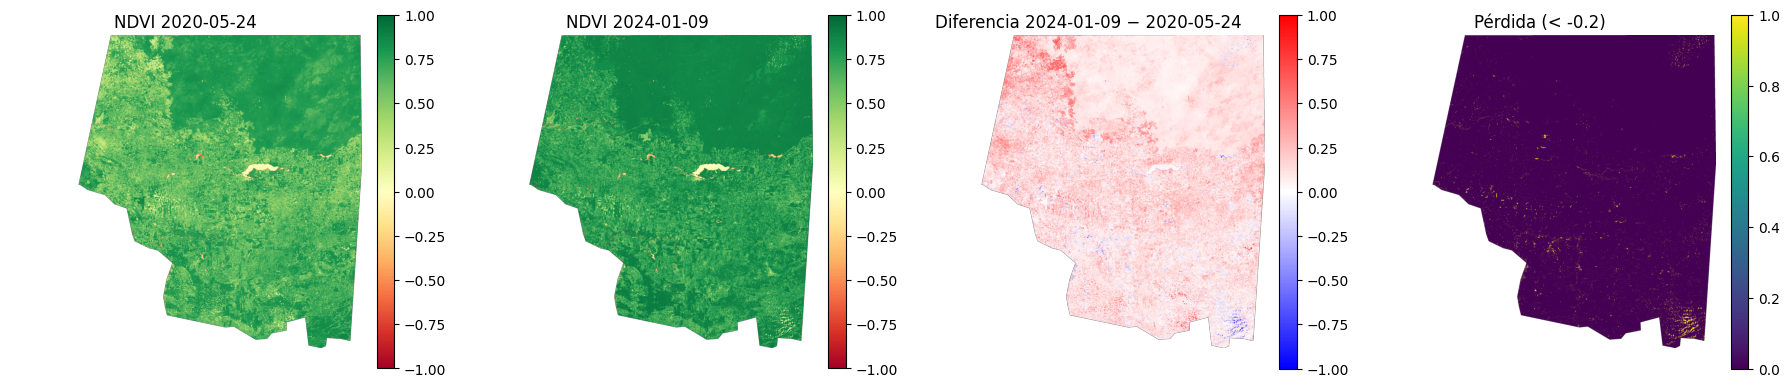

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
im0 = axs[0].imshow(ndvi_by_date[d0], vmin=-1, vmax=1, cmap="RdYlGn"); axs[0].set_title(f"NDVI {d0}"); plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
im1 = axs[1].imshow(ndvi_by_date[d1], vmin=-1, vmax=1, cmap="RdYlGn"); axs[1].set_title(f"NDVI {d1}"); plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
vmax = np.nanmax(np.abs(ndvi_diff.filled(np.nan))); vmax = 0.6 if not np.isfinite(vmax) else min(max(vmax, 0.3), 1.0)
im2 = axs[2].imshow(ndvi_diff, vmin=-vmax, vmax=vmax, cmap="bwr"); axs[2].set_title(f"Diferencia {d1} − {d0}"); plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
im3 = axs[3].imshow(loss_mask, vmin=0, vmax=1); axs[3].set_title(f"Pérdida (< -0.2)"); plt.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04)
for ax in axs: ax.axis("off")
plt.tight_layout(); plt.show()

Entre mayo de 2020 y enero de 2024, se observa una disminución general del NDVI en la región analizada, lo cual indica una reducción en la cobertura vegetal. Las imágenes iniciales muestran una vegetación densa y homogénea, especialmente en zonas verdes intensas, mientras que en la imagen más reciente se nota una leve degradación en ciertas áreas, principalmente al norte y noreste. La diferencia entre ambas fechas revela que predomina una pérdida moderada, representada en tonos rojizos, lo que sugiere deforestación o deterioro ambiental. Al aplicar un umbral de NDVI < -0.2, se identifican claramente focos de pérdida significativa, aunque distribuidos de forma dispersa. Este tipo de análisis permite detectar de manera precisa zonas afectadas por cambios en el uso del suelo, eventos climáticos o actividades humanas, siendo una herramienta clave para monitoreo ambiental y toma de decisiones en conservación.

### Cálculo del área de deforestación


In [13]:
from rasterio.warp import calculate_default_transform
from rasterio.crs import CRS

# --------- Parámetros ----------
threshold = -0.2            # Umbral de pérdida de NDVI
baseline_ndvi_thresh = 0.2  # Umbral para considerar "vegetación" en la fecha inicial

# --------- Utilidades ----------
def parse_date_from_name(name: str):
    m = re.search(r"(20\d{2}-\d{2}-\d{2})", name)
    if m: return m.group(1)
    m = re.search(r"(20\d{6})", name)
    if m:
        d = m.group(1); return f"{d[:4]}-{d[4:6]}-{d[6:]}"
    return name

def pick_files():
    diffs = sorted(OUT_DIR.glob("NDVI_diff_*.tif*"))
    if not diffs:
        raise RuntimeError("No encontré NDVI_diff_*.tif en 'outputs/'. Ejecuta antes el cálculo de NDVI y su diferencia.")
    diff_path = diffs[-1]  # el más reciente

    ndvi_files = sorted(OUT_DIR.glob("NDVI_*.tif*"))
    if len(ndvi_files) < 2:
        print("[AVISO] Sólo hay una fecha NDVI. El % respecto a vegetación inicial no podrá calcularse si no corresponde a la fecha inicial.")
    # Ordena por fecha inferida
    ndvi_files = sorted(ndvi_files, key=lambda p: parse_date_from_name(p.name))
    ndvi_start = ndvi_files[0]  # fecha inicial (p.ej., 2020-..)
    return diff_path, ndvi_start

def utm_crs_from_dataset(ds):
    # Calcula el centro en WGS84 y asigna UTM zona adecuada
    cx = (ds.bounds.left + ds.bounds.right) / 2
    cy = (ds.bounds.top + ds.bounds.bottom) / 2
    lon, lat = rasterio.warp.transform(ds.crs, "EPSG:4326", [cx], [cy])
    lon, lat = lon[0], lat[0]
    zone = int((lon + 180) // 6) + 1
    epsg = (32600 if lat >= 0 else 32700) + zone
    return CRS.from_epsg(epsg)

def reproject_to(ds, src_arr, dst_crs, resampling, dst_transform=None, dst_width=None, dst_height=None, src_nodata=None):
    if dst_transform is None:
        dst_transform, dst_width, dst_height = calculate_default_transform(
            ds.crs, dst_crs, ds.width, ds.height, *ds.bounds
        )
    dst = np.zeros((dst_height, dst_width), dtype=src_arr.dtype)
    reproject(
        source=src_arr,
        destination=dst,
        src_transform=ds.transform,
        src_crs=ds.crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        src_nodata=src_nodata,
        dst_nodata=0,
        resampling=resampling,
    )
    return dst, dst_transform

# --------- Cargar archivos ----------
diff_path, ndvi_start_path = pick_files()
print(f"Usando diferencia: {diff_path.name}")
print(f"Usando NDVI inicial: {ndvi_start_path.name}")

# Lee NDVI_diff como masked array para obtener máscara de válidos
with rasterio.open(diff_path) as dds:
    diff = dds.read(1, masked=True)  # float32 con mask en nodata
    # Válidos donde no hay máscara y el valor es finito
    valid = np.isfinite(diff.filled(np.nan))
    # Máscara de pérdida en la grilla original
    loss_bool = (diff.filled(np.nan) < threshold) & valid

    # Define CRS de salida igual-área (UTM según centro)
    dst_crs = utm_crs_from_dataset(dds)

    # Reproyecta "valid" y "loss" a UTM con vecino más cercano (clasificación)
    valid_u8 = valid.astype("uint8")
    loss_u8  = loss_bool.astype("uint8")

    valid_reproj, dst_transform = reproject_to(dds, valid_u8, dst_crs, Resampling.nearest)
    loss_reproj,  _            = reproject_to(dds, loss_u8,  dst_crs, Resampling.nearest,
                                              dst_transform=dst_transform,
                                              dst_width=valid_reproj.shape[1],
                                              dst_height=valid_reproj.shape[0])

# --------- Vegetación inicial para porcentaje relativo a vegetación ---------
with rasterio.open(ndvi_start_path) as sds:
    ndvi0 = sds.read(1, masked=True).filled(np.nan)
    # Reproyecta NDVI inicial al MISMO grid UTM de arriba (bilinear para continuos)
    ndvi0_reproj, _ = reproject_to(
        sds, ndvi0.astype("float32"), dst_crs, Resampling.bilinear,
        dst_transform=dst_transform,
        dst_width=valid_reproj.shape[1],
        dst_height=valid_reproj.shape[0],
        src_nodata=np.nan
    )
    veg0_bool = np.isfinite(ndvi0_reproj) & (ndvi0_reproj >= baseline_ndvi_thresh)
    # Sólo cuenta vegetación donde también había píxeles válidos en la diferencia
    veg0_bool &= (valid_reproj == 1)

# --------- Cálculo de áreas ----------
# Área de un píxel en m² (abs porque e suele ser negativo)
pix_area_m2 = abs(dst_transform.a * dst_transform.e)

valid_count = int((valid_reproj == 1).sum())
loss_count  = int(((loss_reproj == 1) & (valid_reproj == 1)).sum())
veg0_count  = int(veg0_bool.sum())

area_valid_m2 = valid_count * pix_area_m2
area_loss_m2  = loss_count  * pix_area_m2
area_veg0_m2  = veg0_count  * pix_area_m2

def fm2(m2):  # formateo
    ha = m2 / 10_000
    km2 = m2 / 1_000_000
    return f"{m2:,.0f} m²  |  {ha:,.2f} ha  |  {km2:,.3f} km²"

pct_loss_vs_valid = (area_loss_m2 / area_valid_m2 * 100) if area_valid_m2 > 0 else np.nan
pct_loss_vs_veg0  = (area_loss_m2 / area_veg0_m2 * 100) if area_veg0_m2 > 0 else np.nan

print("\n--- RESUMEN DE DEFORESTACIÓN ---")
print(f"Resolución UTM destino: ~{abs(dst_transform.a):.2f} m")
print(f"Área válida analizada:   {fm2(area_valid_m2)}")
print(f"Área vegetación inicial (NDVI≥{baseline_ndvi_thresh}): {fm2(area_veg0_m2)}")
print(f"Área con pérdida (NDVI_diff<{threshold}): {fm2(area_loss_m2)}")

print("\nPorcentajes:")
print(f"- % deforestación vs área válida:     {pct_loss_vs_valid:.2f} %")
print(f"- % deforestación vs vegetación inicial: {pct_loss_vs_veg0:.2f} %")


Usando diferencia: NDVI_diff_2024-01-09_minus_2020-05-24.tif
Usando NDVI inicial: NDVI_2020-05-24.tif

--- RESUMEN DE DEFORESTACIÓN ---
Resolución UTM destino: ~97.93 m
Área válida analizada:   34,008,673,103 m²  |  3,400,867.31 ha  |  34,008.673 km²
Área vegetación inicial (NDVI≥0.2): 33,612,813,850 m²  |  3,361,281.39 ha  |  33,612.814 km²
Área con pérdida (NDVI_diff<-0.2): 364,050,504 m²  |  36,405.05 ha  |  364.051 km²

Porcentajes:
- % deforestación vs área válida:     1.07 %
- % deforestación vs vegetación inicial: 1.08 %


# Evidencia uso de Copernicus

![Captura de pantalla 2025-08-11 174351.png](<attachment:Captura de pantalla 2025-08-11 174351.png>)
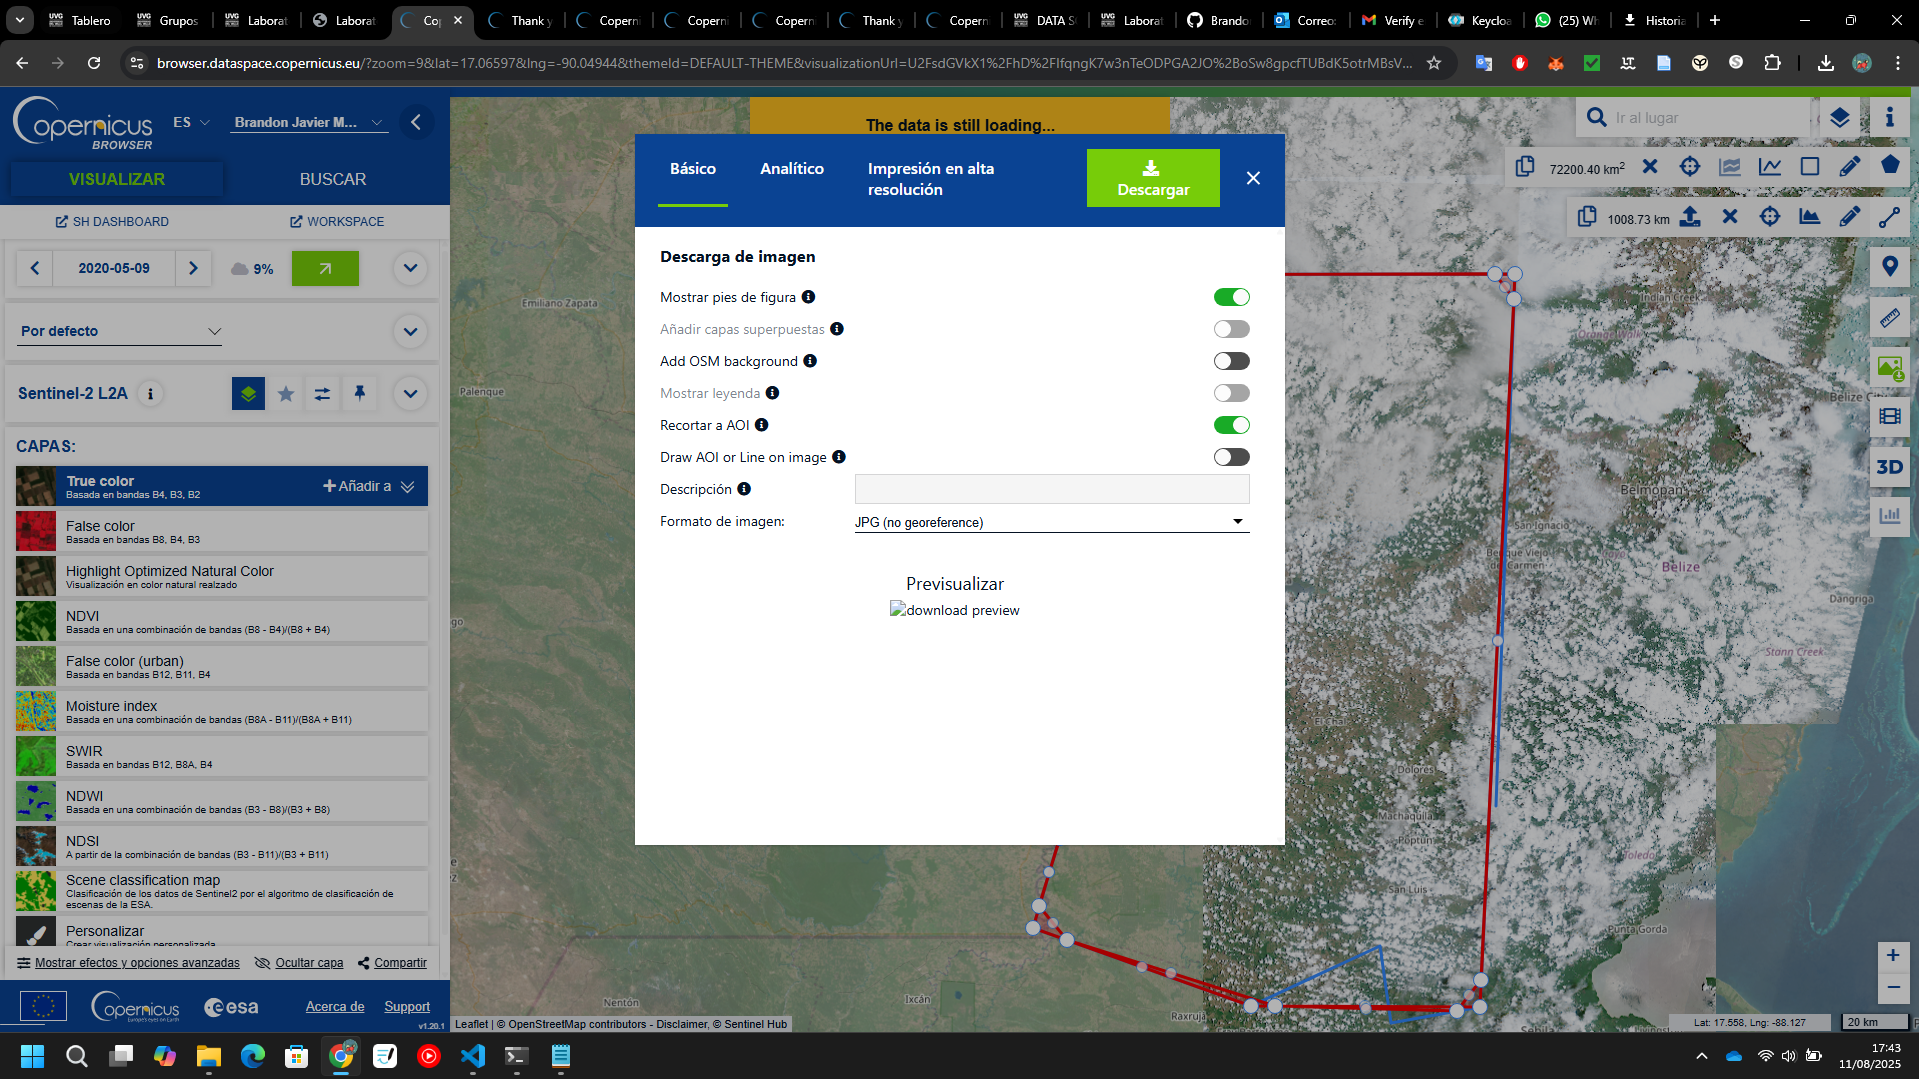

![Captura de pantalla 2025-08-11 174351.png](<attachment:Captura de pantalla 2025-08-11 174351.png>)
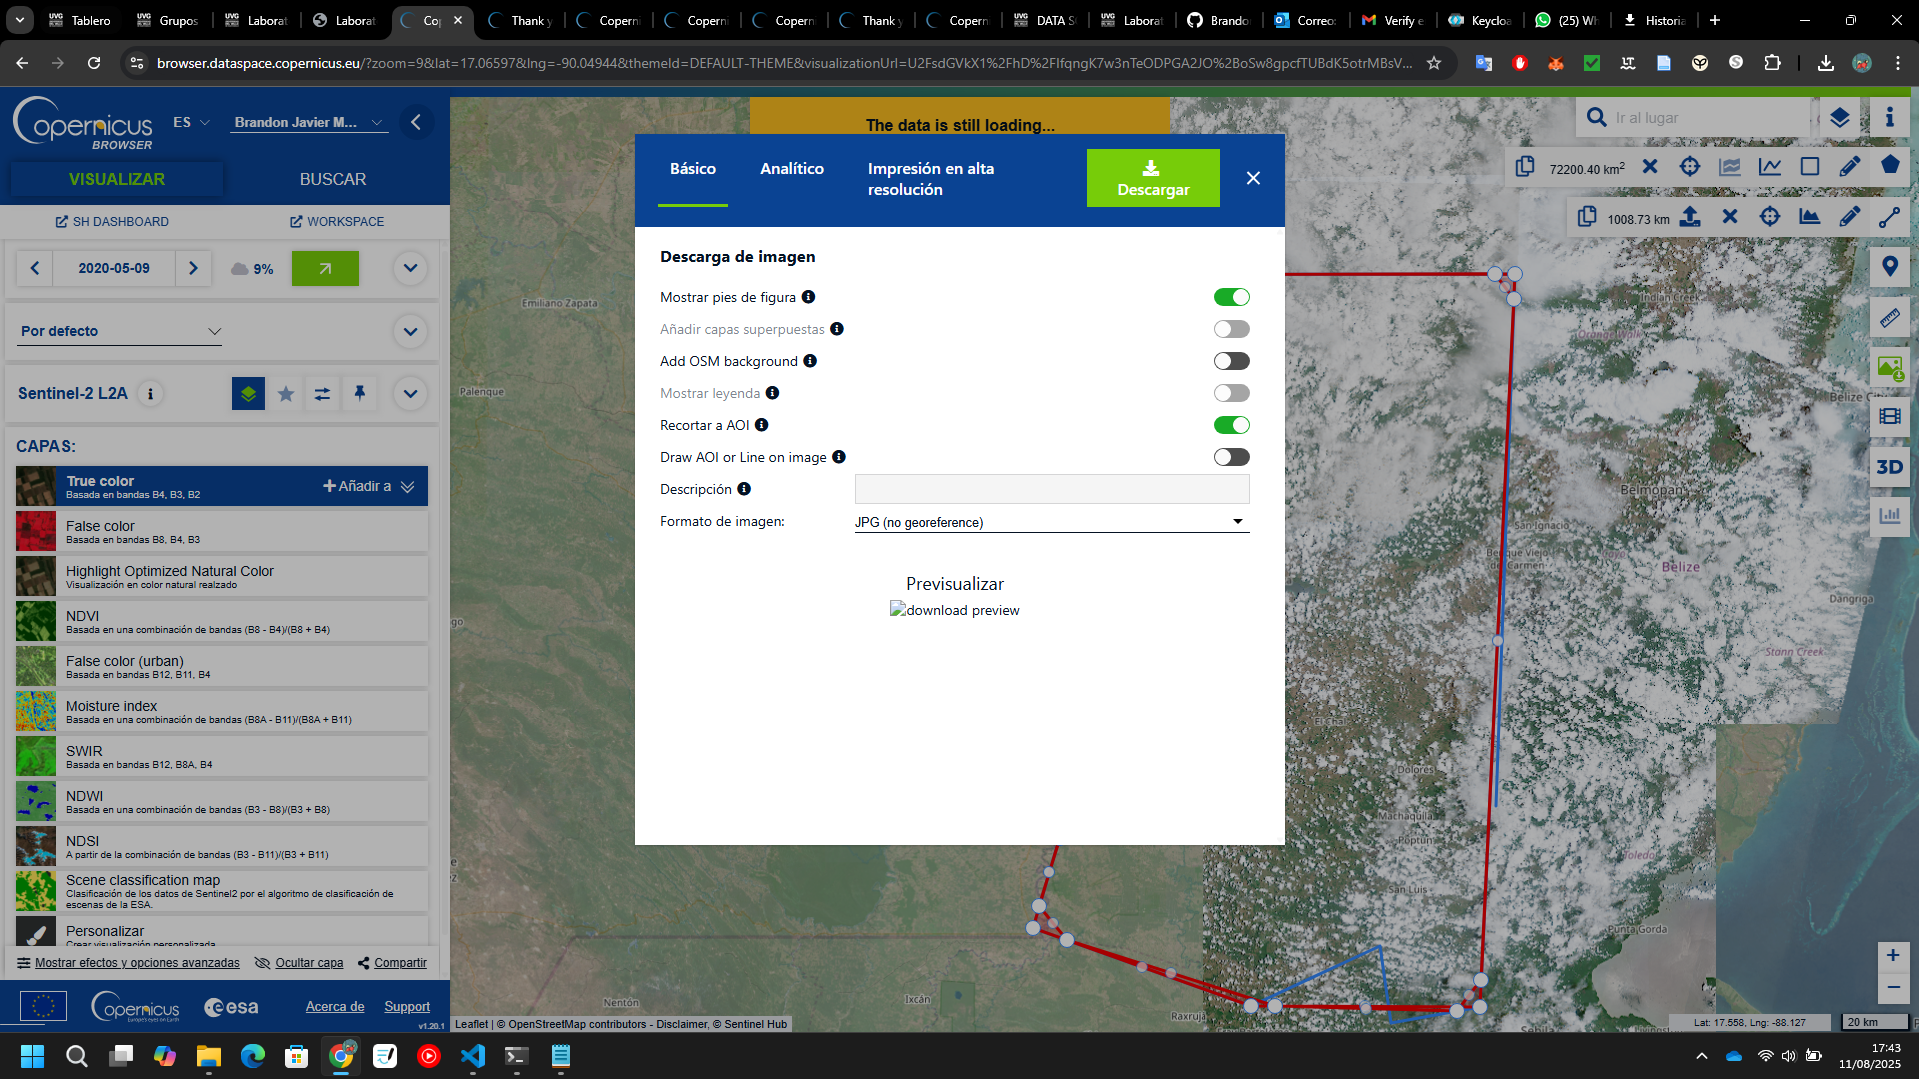